# Identifying matches in pairs of validated floe images

We use an optical flow algorithm to estimate the velocity field from a pair of true color images. For each case, we check whether there are floes in both images. If so, we estimate a flow field, use it to advect the floe shapes from the Terra image to the Aqua image, and create a merged floe properties table.

# Things to note
- Still have some 391 images
- For the manual matching: if drift appears small, unambiguous matches can be retrieved even with no optical flow skill
- Optical flow mainly works if the clouds are thin or absent; for thin clouds, best if cloud cover similar throughout image
- Chance to improve floe labels as well -- many are not as good as I'd like
- Some seem to have wrong name, even!
- Mark down ones that are not expected to work well at all, only attempt the "good" ones

In [84]:
import skimage as sk
import proplot as pplt
import numpy as np
import os
import pandas as pd

from skimage.color import rgba2rgb

In [2]:
modis_loc = "../data/modis/truecolor/"
labeled_loc = "../data/validation_images/labeled_floes/"
labeled_images = [f for f in os.listdir(labeled_loc) if "tiff" in f]

In [7]:
# check that both cases are there 
aqua_cases = list(filter(lambda x: 'aqua' in x, labeled_images))
cases = list(filter(lambda x: x.replace('aqua', 'terra') in labeled_images, aqua_cases))

In [152]:
cases.sort()

In [153]:
# format_tc = '128-hudson_bay-100km-20190415.terra.truecolor.250m.tiff'
# format_lb = 
for case in cases:
    try:
        cn, rg, dt, sat, imtype = case.split('-')
        fpath_tc_aqua = modis_loc + '-'.join([cn, rg, '100km', dt]) + '.'.join(['.aqua', 'truecolor', '250m', 'tiff'])
        fpath_tc_terra = modis_loc + '-'.join([cn, rg, '100km', dt]) + '.'.join(['.terra', 'truecolor', '250m', 'tiff'])
        fpath_lb_aqua = labeled_loc + case
        fpath_lb_terra = labeled_loc + case.replace('aqua', 'terra')
    
    
        # Convert to RGB -- we don't use the opacity layer
        tc_aqua = rgba2rgb(sk.io.imread(fpath_tc_aqua))
        tc_terra = rgba2rgb(sk.io.imread(fpath_tc_terra))
        
        # Convert float to int for label images
        # Also drop the unused channel layer
        lb_aqua = sk.io.imread(fpath_lb_aqua).astype(int)[:,:,0]
        lb_terra = sk.io.imread(fpath_lb_terra).astype(int)[:,:,0]
            
        nr, nc = lb_aqua.shape
        if nr < 400:
            print(case, nr)
        row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
    
        
        # Convert to grayscale for the optical flow algorithms
        # (They're finding a best guess velocity field assuming constant brightness)
        im1 = sk.color.rgb2gray(tc_aqua)
        im2 = sk.color.rgb2gray(tc_terra)
        v, u = sk.registration.optical_flow_ilk(reference_image=im1,
                                              moving_image=im2,
                                              radius=7,
                                              num_warp=10,
                                              gaussian=False, prefilter=False)
        # v0, u0 = sk.registration.optical_flow_tvl1(im1, im2)
    
    
        lb_warp = sk.transform.warp(lb_terra,
                                    np.array([row_coords + v, col_coords + u]),
                                    order=0, mode='constant', cval=0)
        
        regions_aqua = pd.DataFrame(sk.measure.regionprops_table(
            lb_aqua, properties=['label', 'centroid'])).set_index('label')
    
        regions_terra = pd.DataFrame(sk.measure.regionprops_table(
            lb_warp, properties=['label', 'centroid'])).set_index('label')
    
        aqua_labels = np.ravel(lb_aqua)
        terra_labels = np.ravel(lb_warp)
        labels = np.unique(lb_aqua[(lb_aqua > 0) & (lb_warp > 0)])
    
        matches = []
        for label in labels:
            idx = aqua_labels == label
            candidates = np.unique(terra_labels[idx & (terra_labels > 0)])
            for c in candidates:
                iou = np.sum((terra_labels == c) & idx) / np.sum((terra_labels == c) | idx) 
                init_area = np.sum(lb_terra == c)
                warp_area = np.sum(terra_labels == c)
                matches.append([label, c, iou, init_area, warp_area])
        matches = pd.DataFrame(matches, columns=['aqua_label', 'terra_label', 'iou', 'init_area', 'warp_area'])
        if len(matches) > 0:
            for row, data in matches.iterrows():
                r_aqua, c_aqua = regions_aqua.loc[data.aqua_label.astype(int), ['centroid-0', 'centroid-1']]
                r_terra, c_terra = regions_terra.loc[data.terra_label.astype(int), ['centroid-0', 'centroid-1']]
                matches.loc[row, 'r_aqua'] = r_aqua
                matches.loc[row, 'c_aqua'] = c_aqua
                matches.loc[row, 'r_terra'] = r_terra
                matches.loc[row, 'c_terra'] = c_terra
            
            matches['drows'] = matches['r_aqua'] - matches['r_terra']
            matches['dcols'] = matches['c_aqua'] - matches['c_terra']
        lbmask = lambda im: np.ma.masked_array(im, mask=im==0)
    
        fig, axs = pplt.subplots(ncols=3, nrows=2)
        axs[0, 0].imshow(tc_aqua)
        axs[0, 1].imshow(tc_terra)
        # axs[0, 1].imshow(lbmask(lb_aqua), cmap='spectral')
        # axs[1, 1].imshow(lbmask(lb_terra), cmap='spectral')
        
        axs[0, 2].imshow(lbmask(lb_aqua), vmin=0, vmax=1, color='r', alpha=0.5)
        axs[0, 2].imshow(lbmask(lb_terra), vmin=0, vmax=1, color='b', alpha=0.5)
        axs[0, 2].format(title='Overlay of Aqua and Terra labeled floes')
        for c, lw, ms, lb in zip(['r', 'b'],
                                 [0, 0], [10, 10],
                                 ['Aqua', 'Terra']):
            axs[0, 2].plot([], [], color=c, lw=lw, ms=ms, m='s', label=lb)
        axs[0, 2].legend(loc='ur', ncols=1)
        
        
        d = sk.morphology.disk(3)
        
        axs[1, 0].imshow(lbmask(lb_aqua), vmin=0, vmax=1, color='r', alpha=0.25)
        axs[1, 0].imshow(lbmask(lb_terra), vmin=0, vmax=1, color='b', alpha=0.25)
        axs[1, 0].imshow(lbmask(lb_warp - sk.morphology.erosion(lb_warp, footprint=d)), vmin=0, vmax=1, c='k', alpha=1)
        for c, lw, ms, lb in zip(['r', 'b', 'k'],
                                 [0, 0, 1], [10, 10, 0], ['Aqua', 'Terra', 'Terra Warped']):
            axs[1, 0].plot([], [], color=c, lw=lw, ms=ms, m='s', label=lb)
        axs[1, 0].legend(loc='ur', ncols=1)
        # ax.format(yreverse=True, title='Result of Optical Flow')
        # fig.save('../figures/optical_flow_example_166.png', dpi=300)
        if len(matches) > 0:
            axs[1, 1].scatter(matches['c_aqua'], matches['r_aqua'], color='r')
            axs[1, 1].scatter(matches['c_terra'], matches['r_terra'], color='b')
        
        for ax, title in zip(axs, ['Aqua truecolor', 'Terra truecolor', 'Floes Boundaries',
                                   'Advected Floes', 'Paired Floes']):
            ax.format(title=title)
        fig.save('../data/validation_images/' + case.split('-')[0] + '_test_image.png', dpi=300)
        pplt.close(fig)
    except:
        print(case)

036-barents_kara_seas-20200701-aqua-labeled_floes.tiff 391
036-barents_kara_seas-20200701-aqua-labeled_floes.tiff
068-bering_chukchi_seas-20150320-aqua-labeled_floes.tiff 391
068-bering_chukchi_seas-20150320-aqua-labeled_floes.tiff
075-bering_chukchi_seas-20120523-aqua-labeled_floes.tiff 391
075-bering_chukchi_seas-20120523-aqua-labeled_floes.tiff


In [148]:
case
    

'144-hudson_bay-20090605-aqua-labeled_floes.tiff'

In [138]:
matches

,aqua_label,terra_label,iou,init_area,warp_area


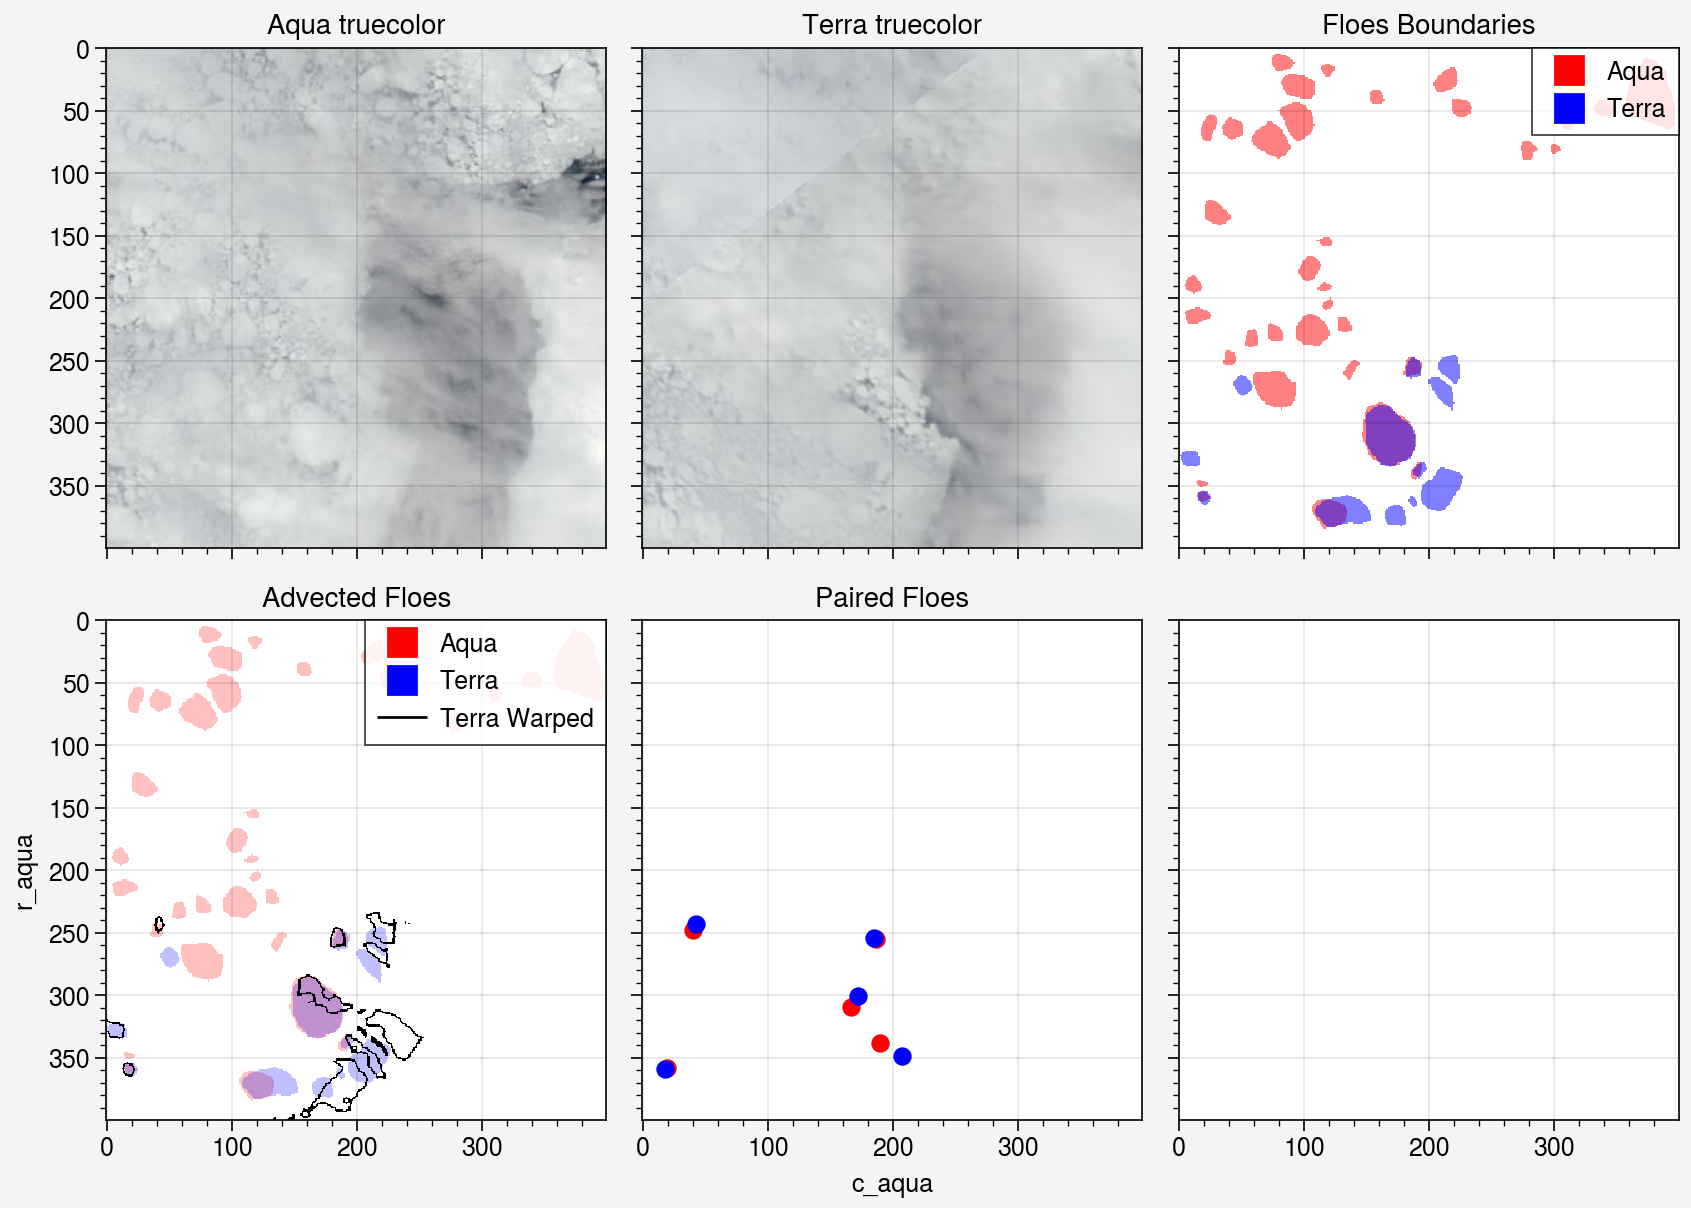

In [147]:
lbmask = lambda im: np.ma.masked_array(im, mask=im==0)

fig, axs = pplt.subplots(ncols=3, nrows=2)
axs[0, 0].imshow(tc_aqua)
axs[0, 1].imshow(tc_terra)
# axs[0, 1].imshow(lbmask(lb_aqua), cmap='spectral')
# axs[1, 1].imshow(lbmask(lb_terra), cmap='spectral')

axs[0, 2].imshow(lbmask(lb_aqua), vmin=0, vmax=1, color='r', alpha=0.5)
axs[0, 2].imshow(lbmask(lb_terra), vmin=0, vmax=1, color='b', alpha=0.5)
axs[0, 2].format(title='Overlay of Aqua and Terra labeled floes')
for c, lw, ms, lb in zip(['r', 'b'],
                         [0, 0], [10, 10],
                         ['Aqua', 'Terra']):
    axs[0, 2].plot([], [], color=c, lw=lw, ms=ms, m='s', label=lb)
axs[0, 2].legend(loc='ur', ncols=1)


d = sk.morphology.disk(3)

axs[1, 0].imshow(lbmask(lb_aqua), vmin=0, vmax=1, color='r', alpha=0.25)
axs[1, 0].imshow(lbmask(lb_terra), vmin=0, vmax=1, color='b', alpha=0.25)
axs[1, 0].imshow(lbmask(lb_warp - sk.morphology.erosion(lb_warp, footprint=d)), vmin=0, vmax=1, c='k', alpha=1)
for c, lw, ms, lb in zip(['r', 'b', 'k'],
                         [0, 0, 1], [10, 10, 0], ['Aqua', 'Terra', 'Terra Warped']):
    axs[1, 0].plot([], [], color=c, lw=lw, ms=ms, m='s', label=lb)
axs[1, 0].legend(loc='ur', ncols=1)
# ax.format(yreverse=True, title='Result of Optical Flow')
# fig.save('../figures/optical_flow_example_166.png', dpi=300)

axs[1, 1].scatter(matches['c_aqua'], matches['r_aqua'], color='r')
axs[1, 1].scatter(matches['c_terra'], matches['r_terra'], color='b')

for ax, title in zip(axs, ['Aqua truecolor', 'Terra truecolor', 'Floes Boundaries',
                           'Advected Floes', 'Paired Floes']):
    ax.format(title=title)

# ax.format(suptitle="Example case: Laptev Sea, Case 166",
#           leftlabels=['Truecolor', 'Manual labels'], toplabels=['Aqua', 'Terra'])
# fig.save("../figures/optical_flow_example_4x4_166.png", dpi=300)

In [128]:
matches['d'] = np.sqrt(matches['drows']**2 + matches['dcols']**2)

In [129]:
matches

,aqua_label,terra_label,iou,r_aqua,c_aqua,r_terra,c_terra,drows,dcols,d
0,4,1,0.099744,63.937984,145.286822,45.030096,192.281806,NaN,NaN,NaN
1,9,2,0.606949,89.445748,156.060117,91.273183,156.160401,NaN,NaN,NaN
2,10,5,0.054366,90.625850,287.836735,110.569980,292.277890,NaN,NaN,NaN
3,13,2,0.057282,96.780069,128.092784,91.273183,156.160401,NaN,NaN,NaN
4,14,2,0.082833,98.365385,185.778846,91.273183,156.160401,NaN,NaN,NaN
5,17,6,0.008338,150.757303,256.906180,125.974194,274.554839,NaN,NaN,NaN
6,17,7,0.062020,150.757303,256.906180,168.272374,277.520752,NaN,NaN,NaN
7,18,8,0.104235,194.145161,205.790323,198.493023,221.986047,-4.347862,-16.195724,16.769179


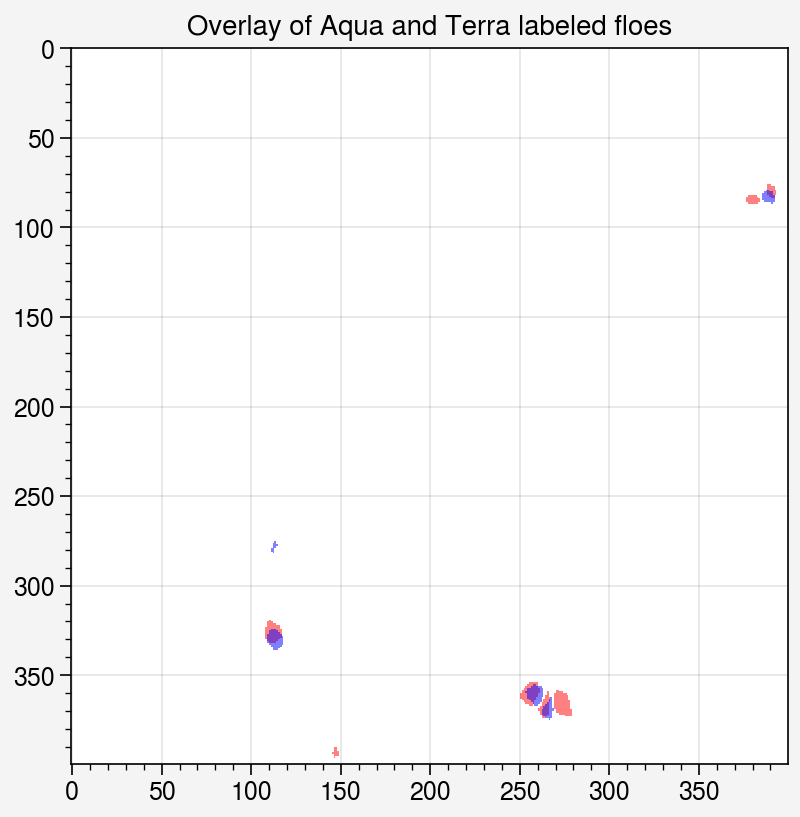

In [154]:
import proplot as pplt
import numpy as np
fig, ax = pplt.subplots(width=4)
ax.imshow(lbmask(lb_aqua), vmin=0, vmax=1, color='r', alpha=0.5)
ax.imshow(lbmask(lb_terra), vmin=0, vmax=1, color='b', alpha=0.5)
ax.format(title='Overlay of Aqua and Terra labeled floes')

Overlapping the images shows that the floes move enough that we can't just look for an overlap, and we also know that there's differences in the velocity across the image. We can enhance contrast in the original image by using the floes as a mask.

In [5]:
im1 = sk.color.rgb2gray(tc_aqua)
im2 = sk.color.rgb2gray(tc_terra)
v, u = sk.registration.optical_flow_ilk(reference_image=im1,
                                      moving_image=im2,
                                      radius=7,
                                      num_warp=10,
                                      gaussian=False, prefilter=False)
v0, u0 = sk.registration.optical_flow_tvl1(im1, im2)

In [6]:
nr, nc = im1.shape
row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
im2_warp = sk.transform.warp(im2, np.array([row_coords + v, col_coords + u]), order=0, mode='constant', cval=0)

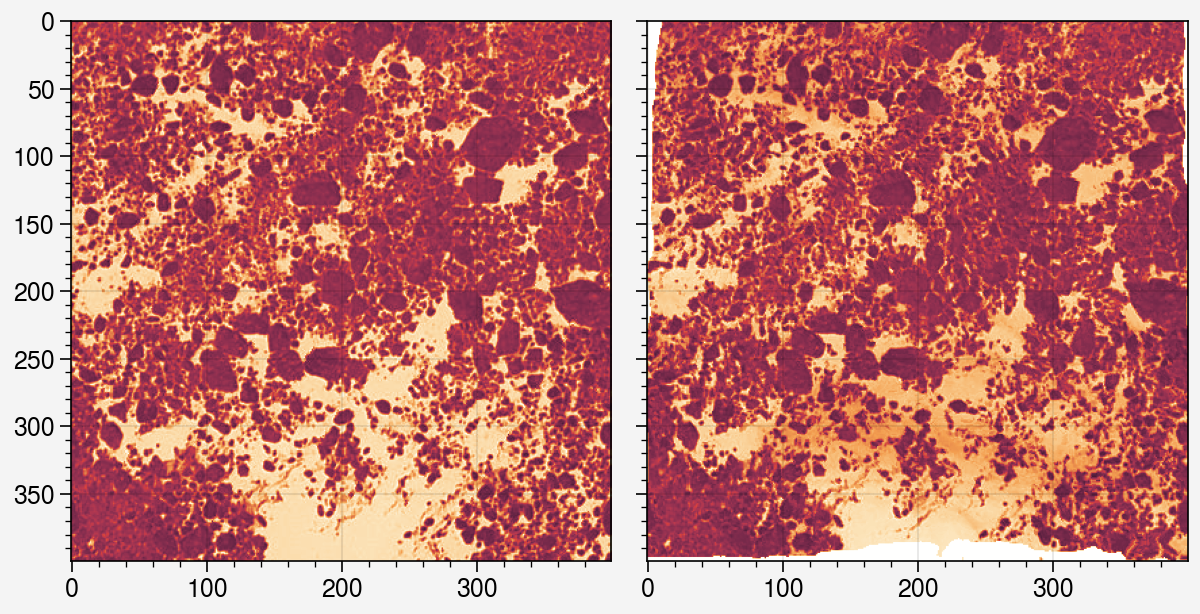

In [7]:
fig, ax = pplt.subplots(width=6, ncols=2)
ax[0].imshow(im1)
ax[1].imshow(im2_warp)

In [9]:
lb_terra_ = sk.measure.label(lb_terra)
lb_warp = sk.transform.warp(lb_terra_[:,:], np.array([row_coords + v, col_coords + u]), order=0, mode='constant', cval=0)

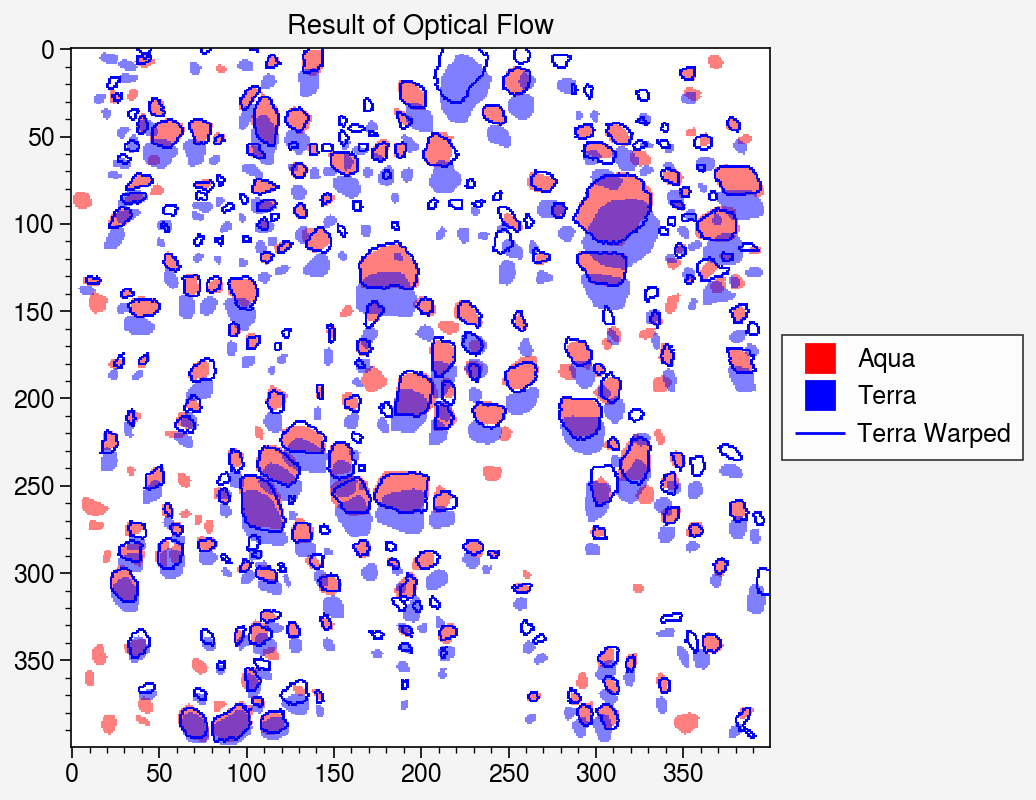

In [26]:
import proplot as pplt
import numpy as np
d = sk.morphology.disk(1)
fig, ax = pplt.subplots(height=4)
ax.pcolormesh(lbmask(lb_aqua), vmin=0, vmax=1, color='r', alpha=0.5)
ax.pcolormesh(lbmask(lb_terra), vmin=0, vmax=1, color='b', alpha=0.5)
ax.pcolormesh(lbmask(lb_warp - sk.morphology.erosion(lb_warp, footprint=d)), c='b', alpha=1)
for c, lw, ms, lb in zip(['r', 'b', 'b'], [0, 0, 1], [10, 10, 0], ['Aqua', 'Terra', 'Terra Warped']):
    ax.plot([], [], color=c, lw=lw, ms=ms, m='s', label=lb)
ax.legend(loc='r', ncols=1)
ax.format(yreverse=True, title='Result of Optical Flow')
fig.save('../figures/optical_flow_example_166.png', dpi=300)

# Findings
For this "easy" image (166), and a harder image (160) optical flow works pretty well! Here's the method:
1. Apply optical flow to the true color images to find the best transform
2. Apply the transform to the labeled image using nearest neighbors and fill edges with 0
3. Pair the labeled image and the warped labeled image using the relevant set method
4. Keep only objects with a single member of the relevant set

Potentially, find the optimal rotation prior to describing the variance in shape parameters.

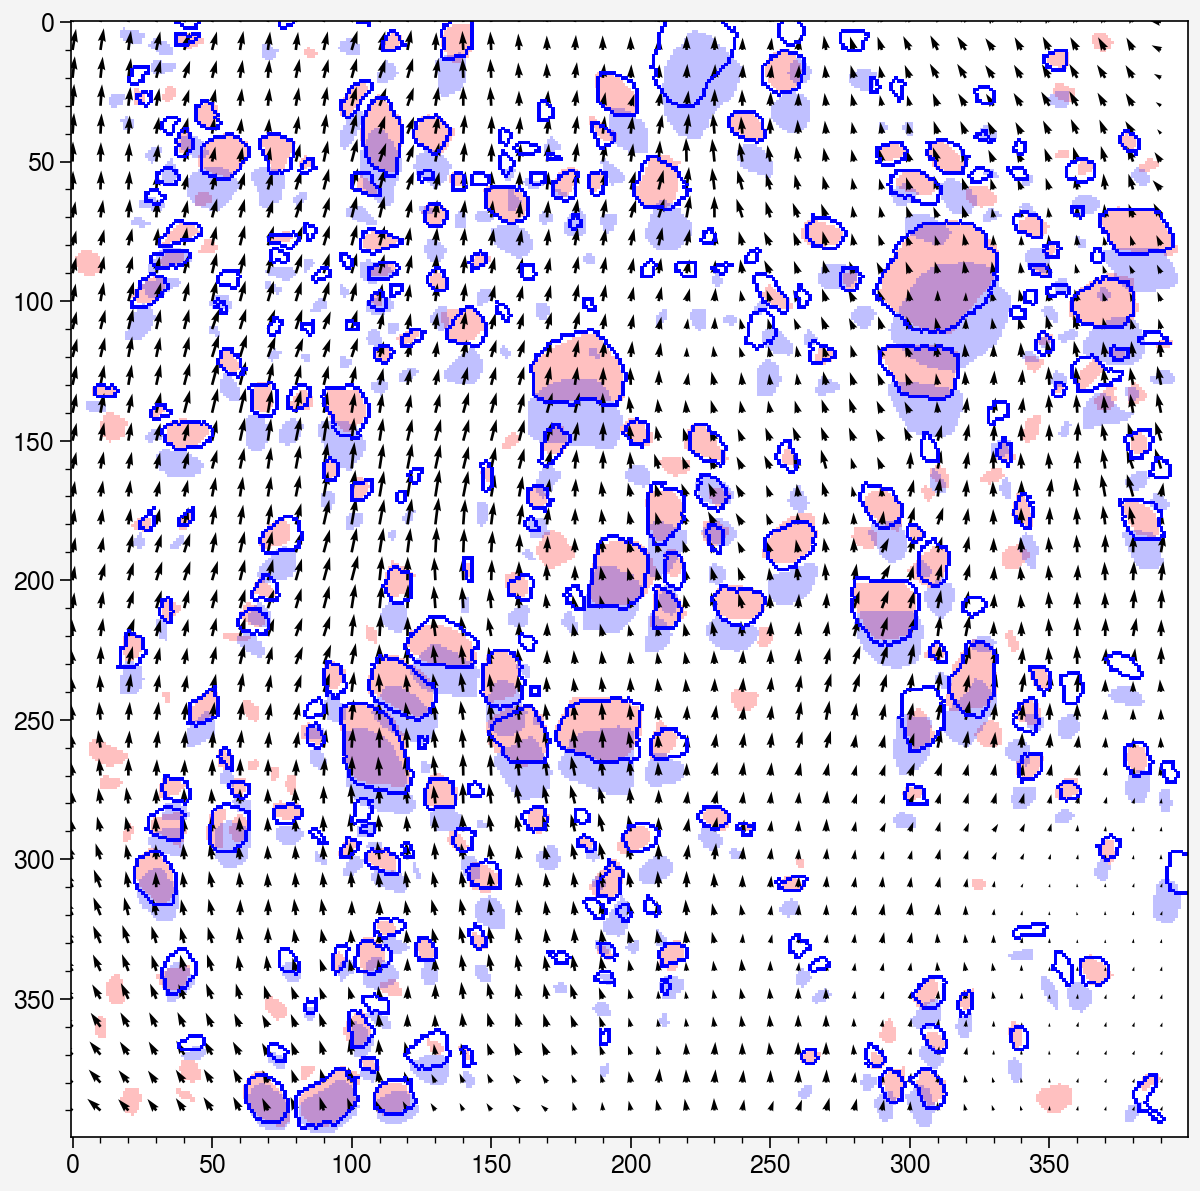

In [39]:
fig, ax = pplt.subplots(width=6)
# Need to figure out the right way to align Quiver with the image orientation convention. Some axis has to get flipped.
ax.quiver(row_coords[::10, ::10], col_coords[::10, ::10], u[::10, ::-10], v[::10, ::-10])
# ax.quiver(row_coords[::10, ::10], col_coords[::10, ::10], u0[::10, ::10], v0[::10, ::10], color='green')
ax.imshow(lbmask(lb_aqua[:,:]), vmin=0, vmax=1, color='r', alpha=0.25)
ax.imshow(lbmask(lb_terra[:,:]), vmin=0, vmax=1, color='b', alpha=0.25)
ax.pcolormesh(lbmask(lb_warp - sk.morphology.erosion(lb_warp, footprint=d)), c='b', alpha=1)
ax.format(yreverse=True)

In [40]:
# simple script: save the labeled images
import skimage as sk
import os
binary_dataloc = "../data/validation_images/binary_floes/"
files = [f for f in os.listdir(binary_dataloc) if 'png' in f]

In [41]:
im = sk.io.imread(binary_dataloc + files[0])

In [75]:
for file in files:
    im = sk.io.imread(binary_dataloc + file)
    labeled_dataloc = binary_dataloc.replace("binary", "labeled")
    labeled_im = sk.measure.label(im).astype(float)
    sk.io.imsave(labeled_dataloc + file.replace("binary", "labeled").replace("png", "tiff"), 
             labeled_im, check_contrast=False)

In [65]:
comp = sk.io.imread(labeled_dataloc + files[0].replace("binary", "labeled").replace("png", "tiff"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


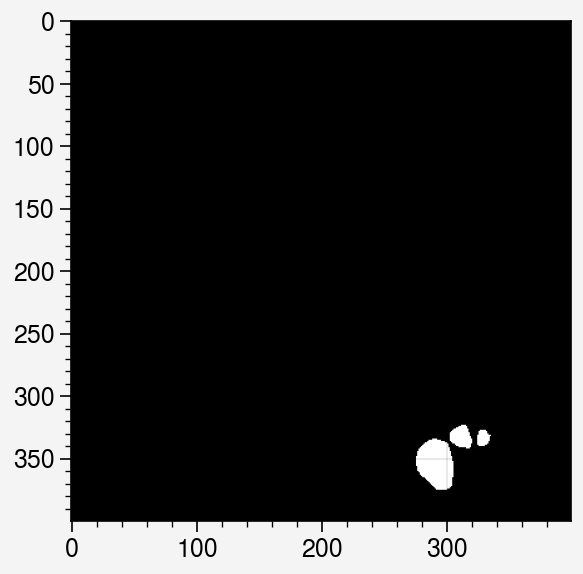

In [67]:
fig, ax = pplt.subplots()
ax.imshow(comp)

In [73]:
comp.astype(int) == test_im

array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       ...,

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,